In [ ]:
# Colab deps
!pip -q install --upgrade openai numpy scipy pandas matplotlib tqdm

import os, getpass, sys, json, random, re, time
import numpy as np
from dataclasses import dataclass
from collections import defaultdict, Counter
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt

# Global random seed for reproducibility of the simulation logic
GLOBAL_SEED = 123
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

# Set API key securely in Colab
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

# OpenAI client (Responses API is the primary interface)
from openai import OpenAI
client = OpenAI()

# Model choice: use gpt-4o-mini to iterate; gpt-4o for strongest results
MODEL = "gpt-4o"
TEMPERATURE = 0.2    # low temperature for style control

print("Ready. Model:", MODEL)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 88.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.5 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.3.5 which is incompatible.
opencv-contrib-python

In [ ]:
def _safe_get_usage(usage):
    """
    Robustly extract token counts from Responses API usage object.
    Works whether attributes are present as fields or dict keys.
    """
    def g(obj, name):
        if obj is None:
            return None
        return getattr(obj, name, None) if not isinstance(obj, dict) else obj.get(name)

    it = g(usage, "input_tokens")
    ot = g(usage, "output_tokens")
    tt = g(usage, "total_tokens")

    # Fallbacks for older fields if present
    if it is None:
        it = g(usage, "prompt_tokens")
    if ot is None:
        ot = g(usage, "completion_tokens")
    if tt is None and it is not None and ot is not None:
        tt = it + ot
    if tt is None:
        tt = 0

    return {"input": it or 0, "output": ot or 0, "total": tt or 0}


def call_model(prompt, model=MODEL, temperature=TEMPERATURE, max_output_tokens=None):
    """
    One shot text generation using the Responses API.

    Returns:
        text: output string from the model
        usage: dict with input/output/total token counts
    """
    kwargs = dict(model=model, temperature=temperature)
    if max_output_tokens is not None:
        kwargs["max_output_tokens"] = max_output_tokens

    # You can send a single text string in "input" for simple calls
    resp = client.responses.create(input=prompt, **kwargs)

    # SDKs expose an output_text helper that aggregates text outputs
    try:
        text = resp.output_text
    except Exception:
        # Fallback: string representation if helper is not available
        text = str(resp)

    usage = _safe_get_usage(getattr(resp, "usage", None))
    return (text or "").strip(), usage


def H_categorical(p):
    """Shannon entropy in bits for a categorical distribution."""
    p = np.asarray(p, dtype=float)
    p = p / p.sum()
    nz = p[p > 0]
    return float(-(nz * np.log2(nz)).sum())


def KL(p, q):
    """KL(p || q) in bits for discrete distributions p, q."""
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    p = p / p.sum()
    q = q / q.sum()
    mask = p > 0
    return float((p[mask] * np.log2(p[mask] / np.clip(q[mask], 1e-12, 1))).sum())

In [ ]:
# Latent user preferences
TONE   = ["formal", "friendly"]
LENGTH = ["short", "medium"]
FORMAT = ["bullets", "paragraph"]

VALUES = {"tone": TONE, "length": LENGTH, "format": FORMAT}

@dataclass
class Task:
    """
    One product description task with a hidden user intent U.
    """
    name: str
    features: list   # list of feature strings
    U: dict          # hidden intent: keys in {"tone","length","format"}


def make_tasks(n=20, seed=0):
    """
    Synthetic product tasks with randomized hidden preferences.
    """
    rnd = random.Random(seed)

    names = [
        "Stainless Steel Bottle",
        "88-Key MIDI Keyboard",
        "Trail Running Shoes",
        "Noise Canceling Headphones",
        "Standing Desk Converter",
        "Smart LED Light Strip",
        "Mechanical Pencil Set",
        "Portable SSD 2TB",
        "Graph Paper Notebook",
        "Ergonomic Office Chair",
    ]
    feats_pool = [
        ["insulated", "24 oz", "BPA free"],
        ["semi weighted keys", "USB C bus powered", "DAW compatible"],
        ["rock plate", "breathable mesh", "4 mm drop"],
        ["ANC", "35h battery", "Bluetooth 5.3"],
        ["fits 13-27 inch monitors", "gas spring", "clamp or grommet"],
        ["16M colors", "music sync", "low power"],
        ["0.5 mm lead", "HB refills", "metal clip"],
        ["USB 3.2 gen 2", "up to 1000 MB per s", "aluminum shell"],
        ["A5", "100 gsm", "200 pages"],
        ["lumbar support", "tilt tension", "mesh back"],
    ]

    tasks = []
    for i in range(n):
        U = {
            "tone":   rnd.choice(TONE),
            "length": rnd.choice(LENGTH),
            "format": rnd.choice(FORMAT),
        }
        tasks.append(Task(
            name=names[i % len(names)],
            features=feats_pool[i % len(feats_pool)],
            U=U,
        ))
    return tasks


def verify(output, task):
    """
    Automatic compliance check for a model output.

    Checks:
      - All feature strings appear literally (case insensitive).
      - Format: bullets vs paragraph.
      - Length: "short" vs "medium" word counts.

    Returns:
      ok (bool), notes (list of strings)
    """
    ok = True
    notes = []

    # Content coverage: require each feature token to appear as a substring
    miss = [f for f in task.features if f.lower() not in output.lower()]
    if miss:
        ok = False
        notes.append(f"Missing features: {miss}")

    # Format check
    if task.U["format"] == "bullets":
        lines = [ln.strip() for ln in output.splitlines() if ln.strip()]
        bullet_like = sum(ln.startswith(("-", "*", "•")) for ln in lines) >= 2
        if not bullet_like:
            ok = False
            notes.append("Expected bullet list.")
    else:
        # For paragraphs, reject obvious bullet formatting
        if "\n-" in output or "\n*" in output or "\n•" in output:
            ok = False
            notes.append("Expected paragraph, not bullets.")

    # Length check
    wc = len(output.split())
    if task.U["length"] == "short" and wc > 70:
        ok = False
        notes.append("Too long for 'short'.")
    if task.U["length"] == "medium" and not (70 <= wc <= 160):
        ok = False
        notes.append("Out of 'medium' band.")

    return ok, notes

In [ ]:
# Clarifying questions (not directly used in simulation, but useful for paper text)
CLARIFY_QS = {
    "tone":   "Before I write, do you prefer a formal or friendly tone?",
    "length": "Do you want a short or a medium length description?",
    "format": "Should I present it as bullet points or as a paragraph?",
}

# Synthetic clarifier token cost
CLARIFY_TOKEN_COST = 12  # tokens charged per clarification

def simulate_user_answer(var, U):
    """User answers truthfully with their hidden preference."""
    return U[var]


def run_session_active(task, model=MODEL, epsilon_bits_per_token=0.01, max_clarifications=3):
    """
    Simple active inference style session:
      - Factorized prior over user attributes.
      - At each step, select the unasked attribute with highest entropy.
      - Stop when entropy per token <= epsilon_bits_per_token or budget is hit.
      - Then generate once with the MAP style.
    """
    # Prior is uniform per attribute (factorized)
    q = {
        "tone":   np.ones(len(TONE))   / len(TONE),
        "length": np.ones(len(LENGTH)) / len(LENGTH),
        "format": np.ones(len(FORMAT)) / len(FORMAT),
    }

    asked = []
    total_tokens = 0
    dkl_bits_log = []

    for _ in range(max_clarifications):
        # Choose the attribute with the largest entropy
        candidates = [(var, H_categorical(q[var])) for var in q if var not in asked]
        if not candidates:
            break
        var, ent_bits = max(candidates, key=lambda kv: kv[1])

        # Stopping rule: if marginal info per token is too small, stop clarifying
        if ent_bits / CLARIFY_TOKEN_COST <= epsilon_bits_per_token:
            break

        # Ask and update (deterministic truthful answer)
        ans = simulate_user_answer(var, task.U)
        p_old = q[var].copy()
        post = np.zeros_like(q[var])
        post[VALUES[var].index(ans)] = 1.0
        q[var] = post

        dkl_bits_log.append(KL(post, p_old))
        total_tokens += CLARIFY_TOKEN_COST
        asked.append(var)

    # Build final prompt from the current MAP style
    style = {k: VALUES[k][int(np.argmax(v))] for k, v in q.items()}

    sys_msg = (
        "You are a concise marketing writer. Follow tone, format, and length exactly. "
        "Reuse the product features as is."
    )
    instr = (
        f"Product: {task.name}\n"
        f"Features: {', '.join(task.features)}\n"
        f"Tone: {style['tone']}\n"
        f"Format: {style['format']}\n"
        f"Length: {style['length']}\n"
        f"Write the description now."
    )
    prompt = f"[System]\n{sys_msg}\n\n[User]\n{instr}"

    out, usage = call_model(prompt, model=model, temperature=0.2, max_output_tokens=220)
    total_tokens += usage["total"]

    ok, notes = verify(out, task)
    IE_1k = 1000.0 * (sum(dkl_bits_log) / max(total_tokens, 1))

    return {
        "asked": asked,
        "style": style,
        "output": out,
        "ok": ok,
        "notes": notes,
        "tokens": total_tokens,
        "IE_1k": IE_1k,
        "features": task.features,
        "truth_U": task.U,
    }


def baseline_direct(task, model=MODEL):
    """
    Baseline with no clarifications and a fixed default style.
    """
    style = {"tone": "formal", "format": "paragraph", "length": "medium"}
    sys_msg = (
        "You are a concise marketing writer. Follow tone, format, and length exactly. "
        "Reuse the product features as is."
    )
    instr = (
        f"Product: {task.name}\n"
        f"Features: {', '.join(task.features)}\n"
        f"Tone: {style['tone']}\n"
        f"Format: {style['format']}\n"
        f"Length: {style['length']}\n"
        f"Write the description now."
    )
    prompt = f"[System]\n{sys_msg}\n\n[User]\n{instr}"

    out, usage = call_model(prompt, model=model, temperature=0.2, max_output_tokens=220)
    ok, notes = verify(out, task)

    return {"ok": ok, "tokens": usage["total"], "IE_1k": 0.0, "output": out, "truth_U": task.U}


# Run a small sanity check experiment
tasks_small = make_tasks(n=12, seed=7)

active_runs = [run_session_active(t, epsilon_bits_per_token=0.01, max_clarifications=3)
               for t in tqdm(tasks_small, desc="Active inference (simple)")]

base_runs = [baseline_direct(t) for t in tqdm(tasks_small, desc="Baseline (fixed style)")]


def summarize_simple(res):
    return {
        "compliance_rate": float(np.mean([r["ok"] for r in res])),
        "avg_tokens": float(np.mean([r["tokens"] for r in res])),
        "IE_1k_avg": float(np.mean([r["IE_1k"] for r in res])),
        "n": len(res),
    }

print("Simple active inference:", json.dumps(summarize_simple(active_runs), indent=2))
print("Simple baseline:", json.dumps(summarize_simple(base_runs), indent=2))

# Show one successful and one failed case
good = next((r for r in active_runs if r["ok"]), active_runs[0])
bad  = next((r for r in active_runs if not r["ok"]), active_runs[0])


def pretty_show(r):
    print("Truth U:", r["truth_U"], "| Asked:", r.get("asked", []), "| Style used:", r.get("style", {}))
    print("Tokens:", r["tokens"], "| IE_1k:", f"{r.get('IE_1k', 0.0):.2f}", "| OK:", r["ok"])
    if r.get("notes"):
        print("Verifier notes:", r["notes"])
    print("\n=== Output ===\n")
    print(r["output"][:1500])


print("\n=== Representative OK case ===")
pretty_show(good)
print("\n\n=== Representative non OK case ===")
pretty_show(bad)

Baseline (fixed style): 100%|██████████| 12/12 [00:31<00:00,  2.65s/it]

Simple active inference: {
  "compliance_rate": 0.4166666666666667,
  "avg_tokens": 162.08333333333334,
  "IE_1k_avg": 18.701093573947144,
  "n": 12
}
Simple baseline: {
  "compliance_rate": 0.0,
  "avg_tokens": 171.66666666666666,
  "IE_1k_avg": 0.0,
  "n": 12
}

=== Representative OK case ===
Truth U: {'tone': 'friendly', 'length': 'short', 'format': 'paragraph'} | Asked: ['tone', 'length', 'format'] | Style used: {'tone': 'friendly', 'length': 'short', 'format': 'paragraph'}
Tokens: 157 | IE_1k: 19.11 | OK: True

=== Output ===

Stay refreshed with our Stainless Steel Bottle! This 24 oz wonder is insulated to keep your drinks at the perfect temperature, whether hot or cold. Plus, it's BPA free, ensuring a safe sip every time. Perfect for on-the-go hydration!


=== Representative non OK case ===
Truth U: {'tone': 'formal', 'length': 'short', 'format': 'bullets'} | Asked: ['tone', 'length', 'format'] | Style used: {'tone': 'formal', 'length': 'short', 'format': 'bullets'}
Tokens: 146 

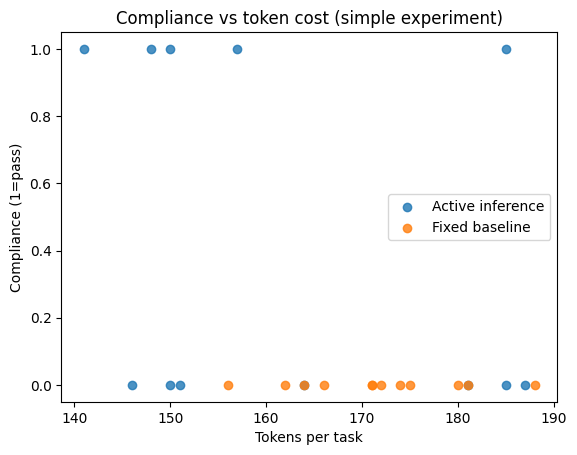

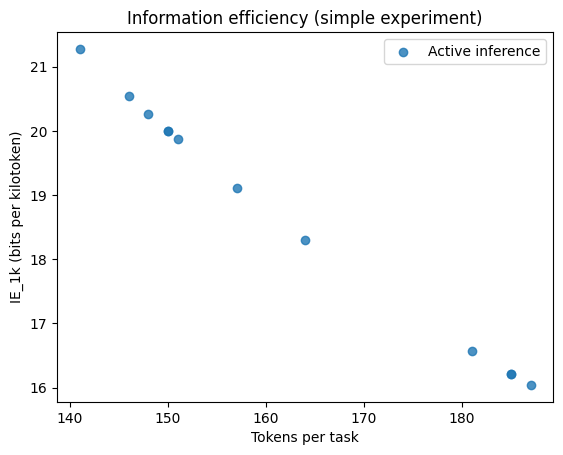

In [ ]:
# Scatter plots: compliance vs token cost and IE vs token cost
acc_active = [1 if r["ok"] else 0 for r in active_runs]
tok_active = [r["tokens"] for r in active_runs]
ie_active  = [r["IE_1k"] for r in active_runs]

acc_base = [1 if r["ok"] else 0 for r in base_runs]
tok_base = [r["tokens"] for r in base_runs]

plt.figure()
plt.scatter(tok_active, acc_active, label="Active inference", alpha=0.8)
plt.scatter(tok_base,   acc_base,   label="Fixed baseline", alpha=0.8)
plt.xlabel("Tokens per task")
plt.ylabel("Compliance (1=pass)")
plt.title("Compliance vs token cost (simple experiment)")
plt.legend()
plt.show()

plt.figure()
plt.scatter(tok_active, ie_active, label="Active inference", alpha=0.8)
plt.xlabel("Tokens per task")
plt.ylabel("IE_1k (bits per kilotoken)")
plt.title("Information efficiency (simple experiment)")
plt.legend()
plt.show()

In [ ]:
# 1) Clarifier realism knobs
NOISY_CLARIFIER   = True     # if True, posterior uses a symmetric noise model
EPS_NOISE         = 0.12     # noise level used in the observation model
COST_SCHEDULE     = [24, 48, 72]  # token cost for the 1st/2nd/3rd clarification

# 2) Compliance weights (format matters more than tone in this toy)
WEIGHT = {"format": 1.0, "length": 0.6, "tone": 0.25}


def clarify_cost(k):
    """k is 1 based index of the clarification within a session."""
    return COST_SCHEDULE[min(k - 1, len(COST_SCHEDULE) - 1)]


def bayes_update_categorical(qvec, observed_idx, eps=EPS_NOISE):
    """
    Symmetric K class noise model:
    P(ans | true = k) = 1 - eps if ans = k, else eps / (K - 1).

    We assume the observed index is "observed_idx" and we know eps,
    so we perform a standard Bayesian update q -> posterior.
    """
    q = np.asarray(qvec, float)
    q = q / q.sum()
    K = len(q)

    like = np.full(K, eps / max(K - 1, 1))
    like[observed_idx] = 1.0 - eps

    post = q * like
    post = post / post.sum()
    return post


def choose_attribute_entropy(q, asked, weight=None, next_cost=24):
    """
    Score each unasked attribute by (weight * entropy) / expected token cost.
    """
    scores = {}
    for v in q:
        if v in asked:
            continue
        ent = H_categorical(q[v])
        w = 1.0 if weight is None else weight.get(v, 1.0)
        scores[v] = (w * ent) / max(next_cost, 1)

    if not scores:
        return None, 0.0

    var = max(scores, key=scores.get)
    return var, scores[var]


def run_session_policy(task, policy="active", epsilon_bits_per_token=0.02,
                       max_clarifications=3, weight=None, model=MODEL):
    """
    General session runner with several policies.

    Policies:
      - "active"          : entropy per token, uniform weights
      - "active_weighted" : entropy per token with compliance weights
      - "ask_all"         : ask all clarifications, then generate
      - "random"          : ask K ~ Uniform{0..max_clarifications}, random order
      - "baseline"        : zero clarifications

    Returns:
      A dict with:
        - ok, notes
        - tokens_total, tokens_evidence
        - IE_1k_session, IE_1k_evidence
        - clarifications
        - fail_types
        - style_used, truth_U, steps (trace), output (text)
    """
    # Factorized prior over intent
    q = {
        "tone":   np.ones(len(TONE))   / len(TONE),
        "length": np.ones(len(LENGTH)) / len(LENGTH),
        "format": np.ones(len(FORMAT)) / len(FORMAT),
    }

    steps = []
    asked = []

    # Decide target K for random policy
    K_rand = random.randint(0, max_clarifications) if policy == "random" else None

    # Clarification phase
    while True:
        if policy == "baseline":
            break
        if len(asked) >= max_clarifications:
            break
        if policy == "random" and len(asked) >= K_rand:
            break

        if policy == "ask_all":
            # pick any remaining attribute deterministically by name order
            remaining = [v for v in ["tone", "length", "format"] if v not in asked]
            var = remaining[0] if remaining else None
            if var is None:
                break
            score = 1.0
        elif policy == "random":
            # random attribute order
            candidates = [v for v in ["tone", "length", "format"] if v not in asked]
            if not candidates:
                break
            var = random.choice(candidates)
            score = 1.0
        else:
            # active and active_weighted
            var, score = choose_attribute_entropy(
                q,
                asked,
                weight if policy == "active_weighted" else None,
                next_cost=clarify_cost(len(asked) + 1),
            )
            if var is None:
                break
            # stop rule for active policies
            if policy in {"active", "active_weighted"} and score <= epsilon_bits_per_token:
                break

        # Update with noisy or exact answer (observation model)
        p_old = q[var].copy()
        true_idx = VALUES[var].index(task.U[var])

        if NOISY_CLARIFIER:
            obs_idx = true_idx
            q[var] = bayes_update_categorical(q[var], obs_idx, eps=EPS_NOISE)
        else:
            post = np.zeros_like(q[var])
            post[true_idx] = 1.0
            q[var] = post

        dkl_bits = KL(q[var], p_old)
        ct = clarify_cost(len(asked) + 1)
        steps.append({
            "type": "clarify",
            "var": var,
            "dkl_bits": float(dkl_bits),
            "tokens": int(ct),
        })
        asked.append(var)

    # Final generation
    style = {k: VALUES[k][int(np.argmax(v))] for k, v in q.items()}

    sys_msg = (
        "You are a concise marketing writer. Follow tone, format, and length exactly. "
        "Reuse the product features as is."
    )
    instr = (
        f"Product: {task.name}\n"
        f"Features: {', '.join(task.features)}\n"
        f"Tone: {style['tone']}\n"
        f"Format: {style['format']}\n"
        f"Length: {style['length']}\n"
        f"Write the description now."
    )
    prompt = f"[System]\n{sys_msg}\n\n[User]\n{instr}"

    out, usage = call_model(prompt, model=model, temperature=0.2, max_output_tokens=220)
    steps.append({
        "type": "generate",
        "var": None,
        "dkl_bits": 0.0,
        "tokens": int(usage["total"]),
    })

    # Verify
    ok, notes = verify(out, task)

    # Summary metrics
    bits_evidence = sum(s["dkl_bits"] for s in steps if s["type"] == "clarify")
    tok_evidence  = sum(s["tokens"] for s in steps if s["type"] == "clarify")
    tok_total     = sum(s["tokens"] for s in steps)

    IE_1k_evidence = 1000.0 * bits_evidence / max(tok_evidence, 1)
    IE_1k_session  = 1000.0 * bits_evidence / max(tok_total, 1)

    # Failure type tags
    ftypes = []
    for n in notes:
        s = n.lower()
        if "missing features" in s:
            ftypes.append("content")
        if "expected bullet" in s or "paragraph" in s:
            ftypes.append("format")
        if "long" in s or "medium" in s:
            ftypes.append("length")
    if not ftypes and not ok:
        ftypes = ["other"]

    # Store marginal bits per clarification index
    marg_bits = [s["dkl_bits"] for s in steps if s["type"] == "clarify"]
    while len(marg_bits) < 3:
        marg_bits.append(np.nan)

    return {
        "policy": policy,
        "ok": int(ok),
        "clarifications": len(asked),
        "tokens_total": tok_total,
        "tokens_evidence": tok_evidence,
        "IE_1k_session": IE_1k_session,
        "IE_1k_evidence": IE_1k_evidence,
        "mbit_1": marg_bits[0],
        "mbit_2": marg_bits[1],
        "mbit_3": marg_bits[2],
        "fail_types": ftypes,
        "notes": notes,
        "style_used": style,
        "truth_U": task.U,
        "steps": steps,
        "output": out,
    }

In [ ]:
# More tasks for denser plots. Increase with care since each task generates once.
N_TASKS = 48
tasks = make_tasks(n=N_TASKS, seed=42)

POLICIES = [
    ("active",          {"epsilon_bits_per_token": 0.02, "max_clarifications": 3}),
    ("active_weighted", {"epsilon_bits_per_token": 0.02, "max_clarifications": 3}),
    ("ask_all",         {"max_clarifications": 3}),
    ("random",          {"max_clarifications": 3}),
    ("baseline",        {}),
]

rows = []
for name, cfg in POLICIES:
    for i, t in enumerate(tqdm(tasks, desc=f"Policy={name}")):
        res = run_session_policy(
            t,
            policy=name,
            epsilon_bits_per_token=cfg.get("epsilon_bits_per_token", 0.0),
            max_clarifications=cfg.get("max_clarifications", 0),
            weight=WEIGHT if name == "active_weighted" else None,
            model=MODEL,
        )
        res["task_id"] = i
        rows.append(res)

df = pd.DataFrame(rows)
df.head()

Policy=baseline: 100%|██████████| 48/48 [01:49<00:00,  2.29s/it]


,policy,ok,clarifications,tokens_total,tokens_evidence,IE_1k_session,IE_1k_evidence,mbit_1,mbit_2,mbit_3,fail_types,notes,style_used,truth_U,steps,output,task_id
0,active,0,2,175,72,5.378733,13.073309,0.470639,0.470639,NaN,[format],"[Expected paragraph, not bullets.]","{'tone': 'formal', 'length': 'short', 'format'...","{'tone': 'formal', 'length': 'short', 'format'...","[{'type': 'clarify', 'var': 'tone', 'dkl_bits'...",- Premium stainless steel construction\n- Insu...,0
1,active,0,2,187,72,5.033574,13.073309,0.470639,0.470639,NaN,[content],"[Missing features: ['semi weighted keys', 'DAW...","{'tone': 'formal', 'length': 'short', 'format'...","{'tone': 'formal', 'length': 'short', 'format'...","[{'type': 'clarify', 'var': 'tone', 'dkl_bits'...",- Experience authentic touch with **semi-weigh...,1
2,active,0,2,177,72,5.317956,13.073309,0.470639,0.470639,NaN,[format],"[Expected paragraph, not bullets.]","{'tone': 'formal', 'length': 'short', 'format'...","{'tone': 'formal', 'length': 'short', 'format'...","[{'type': 'clarify', 'var': 'tone', 'dkl_bits'...",- Equipped with a durable rock plate for enhan...,2
3,active,0,2,185,72,5.087991,13.073309,0.470639,0.470639,NaN,[content],[Missing features: ['35h battery']],"{'tone': 'formal', 'length': 'short', 'format'...","{'tone': 'formal', 'length': 'short', 'format'...","[{'type': 'clarify', 'var': 'tone', 'dkl_bits'...",- Advanced Active Noise Cancellation (ANC) for...,3
4,active,0,2,186,72,5.060636,13.073309,0.470639,0.470639,NaN,[content],[Missing features: ['fits 13-27 inch monitors']],"{'tone': 'formal', 'length': 'short', 'format'...","{'tone': 'formal', 'length': 'short', 'format'...","[{'type': 'clarify', 'var': 'tone', 'dkl_bits'...",- Accommodates 13-27 inch monitors for versati...,4


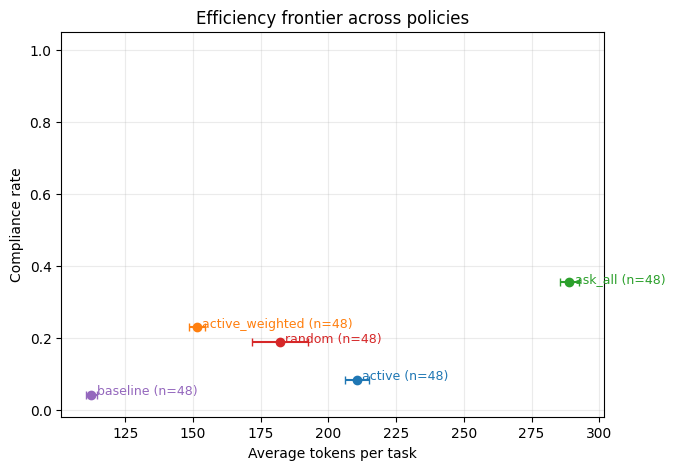

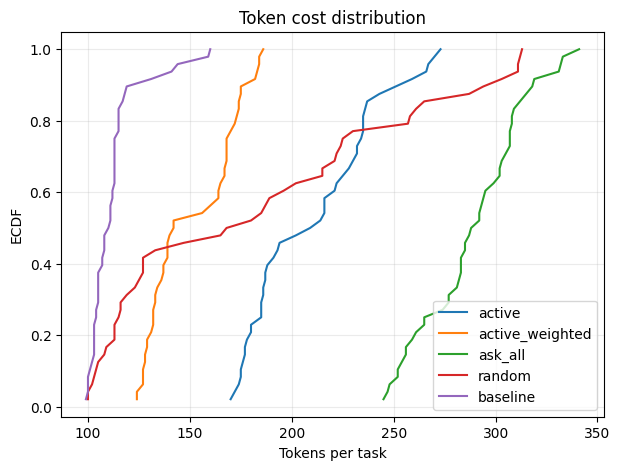

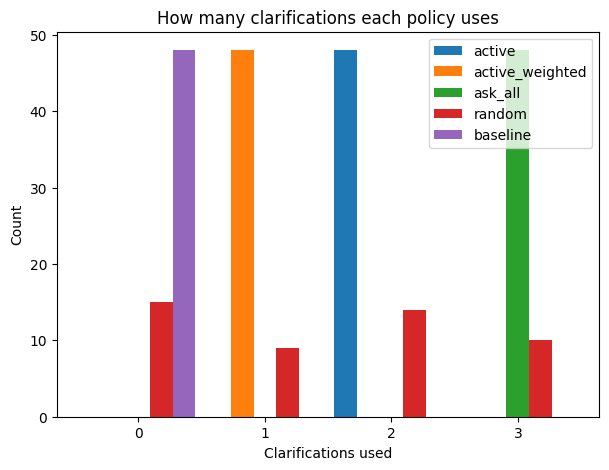

/tmp/ipython-input-3486789046.py:73: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=policies, showmeans=True)


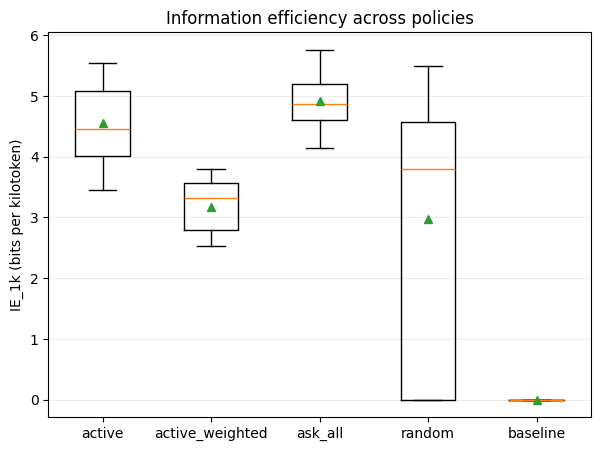

In [ ]:
# Visualization: efficiency frontier, token distributions, failure modes, timelines

plt.rcParams.update({"figure.figsize": (7.0, 5.0)})

def agg(df_local, by="policy"):
    g = df_local.groupby(by)
    return (
        g["ok"].mean(),
        g["tokens_total"].mean(),
        g["tokens_total"].std() / np.sqrt(g.size()),
        g.size(),
    )

policies = df["policy"].unique().tolist()
colors = {p: c for p, c in zip(policies, plt.cm.tab10.colors[:len(policies)])}

# 1) Efficiency frontier: compliance vs average tokens with error bars
acc, tok_mean, tok_sem, n = agg(df)
plt.figure()
for p in policies:
    x = tok_mean[p]
    y = acc[p]
    plt.errorbar(x, y, xerr=tok_sem[p], fmt="o", color=colors[p], capsize=3)
    plt.text(x + 2, y, f"{p} (n={n[p]})", fontsize=9, color=colors[p])
plt.xlabel("Average tokens per task")
plt.ylabel("Compliance rate")
plt.title("Efficiency frontier across policies")
plt.ylim(-0.02, 1.05)
plt.grid(True, alpha=0.25)
plt.show()

# 2) ECDF of tokens per task
def ecdf(x):
    x = np.sort(np.asarray(x))
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

plt.figure()
for p in policies:
    xs, ys = ecdf(df.loc[df.policy == p, "tokens_total"])
    plt.plot(xs, ys, label=p, color=colors[p])
plt.xlabel("Tokens per task")
plt.ylabel("ECDF")
plt.title("Token cost distribution")
plt.legend()
plt.grid(True, alpha=0.25)
plt.show()

# 3) Distribution of number of clarifications
plt.figure()
bins = np.arange(-0.5, 4.5, 1.0)
width = 0.18
for j, p in enumerate(policies):
    counts, _ = np.histogram(df.loc[df.policy == p, "clarifications"], bins=bins)
    centers = np.arange(0, 4)
    plt.bar(
        centers + (j - len(policies) / 2) * width + width / 2,
        counts,
        width=width,
        label=p,
        color=colors[p],
    )
plt.xticks([0, 1, 2, 3], ["0", "1", "2", "3"])
plt.xlabel("Clarifications used")
plt.ylabel("Count")
plt.title("How many clarifications each policy uses")
plt.legend()
plt.show()

# 4) IE_1k boxplot by policy
plt.figure()
data = [df.loc[df.policy == p, "IE_1k_session"].dropna().values for p in policies]
plt.boxplot(data, labels=policies, showmeans=True)
plt.ylabel("IE_1k (bits per kilotoken)")
plt.title("Information efficiency across policies")
plt.grid(True, axis="y", alpha=0.25)
plt.show()


In [ ]:
# Bilevel style hyperparameter search over clarification threshold and budget

# Training and test sets for the outer loop
N_TASKS_TRAIN = 24
N_TASKS_TEST  = 24

tasks_train = make_tasks(n=N_TASKS_TRAIN, seed=100)
tasks_test  = make_tasks(n=N_TASKS_TEST,  seed=101)

# Tradeoff coefficient: how much we penalize tokens relative to compliance
# J = E[ok] - lambda_cost * (E[tokens_total] / 1000)
lambda_cost = 0.02

eps_grid = [0.0, 0.005, 0.01, 0.02, 0.04]
max_clar_grid = [1, 2, 3]

outer_records = []

for eps in eps_grid:
    for mc in max_clar_grid:
        rows_cfg = []
        desc = f"train active_weighted eps={eps:.3f}, K={mc}"
        for i, t in enumerate(tqdm(tasks_train, desc=desc)):
            res = run_session_policy(
                t,
                policy="active_weighted",          # bugfix: use implemented policy label
                epsilon_bits_per_token=eps,
                max_clarifications=mc,
                weight=WEIGHT,
                model=MODEL,
            )
            res["config_eps"] = eps
            res["config_max_clar"] = mc
            rows_cfg.append(res)

        df_cfg = pd.DataFrame(rows_cfg)
        E_ok = df_cfg["ok"].mean()
        E_tokens = df_cfg["tokens_total"].mean()
        E_clar = df_cfg["clarifications"].mean()
        J = float(E_ok - lambda_cost * (E_tokens / 1000.0))

        outer_records.append({
            "epsilon": eps,
            "max_clarifications": mc,
            "E_ok_train": float(E_ok),
            "E_tokens_train": float(E_tokens),
            "E_clar_train": float(E_clar),
            "J_train": J,
        })

outer_df = pd.DataFrame(outer_records).sort_values("J_train", ascending=False)
print("Top hyperparameter settings on the training set (sorted by J):")
outer_df.head(10)

train active_weighted eps=0.040, K=3: 100%|██████████| 24/24 [00:54<00:00,  2.26s/it]

Top hyperparameter settings on the training set (sorted by J):


,epsilon,max_clarifications,E_ok_train,E_tokens_train,E_clar_train,J_train
7,0.010,2,0.458333,218.750000,2.0,0.453958
2,0.000,3,0.458333,292.125000,3.0,0.452491
8,0.010,3,0.416667,215.958333,2.0,0.412348
1,0.000,2,0.416667,218.333333,2.0,0.412300
4,0.005,2,0.375000,218.666667,2.0,0.370627
5,0.005,3,0.375000,219.583333,2.0,0.370608
12,0.040,1,0.291667,155.125000,1.0,0.288564
9,0.020,1,0.291667,156.041667,1.0,0.288546
0,0.000,1,0.291667,157.083333,1.0,0.288525
11,0.020,3,0.250000,153.083333,1.0,0.246938


In [ ]:
# Evaluate best configuration from outer loop on held out test tasks

best = outer_df.iloc[0]
best_eps = float(best["epsilon"])
best_mc  = int(best["max_clarifications"])

print("Best configuration from training:")
print(best)

# Evaluate active_weighted with best hyperparameters on test tasks
rows_test_best = []
for i, t in enumerate(tqdm(tasks_test, desc="Best config on test")):
    res = run_session_policy(
        t,
        policy="active_weighted",
        epsilon_bits_per_token=best_eps,
        max_clarifications=best_mc,
        weight=WEIGHT,
        model=MODEL,
    )
    rows_test_best.append(res)
df_test_best = pd.DataFrame(rows_test_best)

# Evaluate a baseline with no clarifications on test tasks
rows_test_base = []
for i, t in enumerate(tqdm(tasks_test, desc="Baseline on test")):
    res = run_session_policy(
        t,
        policy="baseline",
        epsilon_bits_per_token=0.0,
        max_clarifications=0,
        weight=None,
        model=MODEL,
    )
    rows_test_base.append(res)
df_test_base = pd.DataFrame(rows_test_base)

summary_test = {
    "active_weighted": {
        "E_ok": float(df_test_best["ok"].mean()),
        "E_tokens": float(df_test_best["tokens_total"].mean()),
        "E_clar": float(df_test_best["clarifications"].mean()),
    },
    "baseline": {
        "E_ok": float(df_test_base["ok"].mean()),
        "E_tokens": float(df_test_base["tokens_total"].mean()),
        "E_clar": float(df_test_base["clarifications"].mean()),
    },
}

print("Test set comparison (best active policy vs baseline):")
print(json.dumps(summary_test, indent=2))

Best configuration from training:
epsilon                 0.010000
max_clarifications      2.000000
E_ok_train              0.458333
E_tokens_train        218.750000
E_clar_train            2.000000
J_train                 0.453958
Name: 7, dtype: float64


Baseline on test: 100%|██████████| 24/24 [00:55<00:00,  2.31s/it]

Test set comparison (best active policy vs baseline):
{
  "active_weighted": {
    "E_ok": 0.375,
    "E_tokens": 218.95833333333334,
    "E_clar": 2.0
  },
  "baseline": {
    "E_ok": 0.041666666666666664,
    "E_tokens": 111.5,
    "E_clar": 0.0
  }
}
